In [66]:
import datetime as dt
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import dump, load
from math import sqrt
from keras.layers import Dense, GRU, LSTM
from keras.optimizers import Adam
from keras.models import Sequential, load_model
import warnings
warnings.filterwarnings('ignore')

## 1. Data Preprocessing

In [67]:
dataset = pd.read_csv('EURUSD_2000_2023.csv', parse_dates=True)
dataset.Date = pd.to_datetime(dataset.Date, dayfirst=True)
dataset = dataset.set_index(dataset.Date)
dataset = dataset.drop("Date", axis='columns')
dataset = dataset.drop("ZigZag", axis='columns')
dataset

,Open,High,Low,Close,Return_rate,RSI_7,RSI_14,MA_7,MA_14
Date,,,,,,,,,
2000-01-18,1.01110,1.01550,1.00720,1.01400,1.002769,36.106221,41.847381,1.019714,1.024307
2000-01-19,1.01410,1.01650,1.00850,1.01170,0.997732,32.411299,39.100201,1.016786,1.023271
2000-01-20,1.01160,1.01880,1.00730,1.01690,1.005140,46.777470,47.492823,1.014700,1.022393
2000-01-21,1.01660,1.01930,1.00500,1.00870,0.991936,33.627629,38.485863,1.012514,1.020707
2000-01-23,1.00280,1.00450,1.00260,1.00430,0.995638,28.595350,34.684738,1.011386,1.018836
...,...,...,...,...,...,...,...,...,...
2022-12-07,1.04670,1.05493,1.04427,1.05114,1.004223,64.103095,64.267401,1.050111,1.043287
2022-12-08,1.05115,1.05643,1.04892,1.05551,1.004157,69.392195,66.614241,1.052003,1.045037
2022-12-09,1.05549,1.05878,1.05032,1.05325,0.997859,63.726914,64.263552,1.052074,1.045859


In [68]:
X_value = pd.DataFrame(dataset.iloc[:, :])
y_value = pd.DataFrame(dataset.Close)

In [69]:
X_value.head()

,Open,High,Low,Close,Return_rate,RSI_7,RSI_14,MA_7,MA_14
Date,,,,,,,,,
2000-01-18,1.0111,1.0155,1.0072,1.0140,1.002769,36.106221,41.847381,1.019714,1.024307
2000-01-19,1.0141,1.0165,1.0085,1.0117,0.997732,32.411299,39.100201,1.016786,1.023271
2000-01-20,1.0116,1.0188,1.0073,1.0169,1.005140,46.777470,47.492823,1.014700,1.022393
2000-01-21,1.0166,1.0193,1.0050,1.0087,0.991936,33.627629,38.485863,1.012514,1.020707
2000-01-23,1.0028,1.0045,1.0026,1.0043,0.995638,28.595350,34.684738,1.011386,1.018836


In [70]:
y_value.head()

,Close
Date,
2000-01-18,1.0140
2000-01-19,1.0117
2000-01-20,1.0169
2000-01-21,1.0087
2000-01-23,1.0043


In [71]:
# Normalized the data
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)

dump(X_scaler, open('PredictionData/X_scaler.pkl', 'wb'))
dump(y_scaler, open('PredictionData/y_scaler.pkl', 'wb'))

In [72]:
n_steps_in = 30
n_features = X_value.shape[1]
n_steps_out = 5
print(n_features)

9


In [73]:
def get_X_y(X_data, y_data):
    X = list()
    y = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        if len(X_value) == n_steps_in and len(y_value) == n_steps_out:
            X.append(X_value)
            y.append(y_value)

    return np.array(X), np.array(y)

In [74]:
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index

In [75]:
def split_train_test(data):
    train_size = round(len(data) * 0.7)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [76]:
X, y = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
train_predict_index, test_predict_index, = predict_index(dataset, X_train, n_steps_in, n_steps_out)
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('index_train shape:', train_predict_index.shape)
print('index_test shape:', test_predict_index.shape)

X shape:  (7106, 30, 9)
y shape:  (7106, 5)
X_train shape:  (4974, 30, 9)
y_train shape:  (4974, 5)
X_test shape:  (2132, 30, 9)
y_test shape:  (2132, 5)
index_train shape: (4978,)
index_test shape: (2136,)


In [77]:
def get_simulation_data(test_index, output_dim):
    org_dataset = pd.read_csv('EURUSD_DATASET.csv', parse_dates=True)
    org_dataset.Date = pd.to_datetime(org_dataset.Date, dayfirst=True)
    org_dataset = org_dataset.set_index(org_dataset.Date)
    org_dataset = org_dataset.drop("ZigZag", axis='columns')

    sim_indexes = pd.DataFrame()
    sim_indexes['Date'] = test_index
    sim_indexes['Date'] = pd.to_datetime(sim_indexes['Date'], dayfirst=True)
    sim_indexes = sim_indexes.set_index(sim_indexes['Date'])
    sim_indexes.drop("Date", axis='columns')

    sim_dataset = org_dataset.loc[org_dataset.index.isin(sim_indexes.index)]
    cutDays = output_dim - 1
    sim_dataset = sim_dataset.iloc[:-cutDays]

    sim_dataset.to_csv('PredictionData/Simulation_Dataset.csv', index=False)

In [78]:
print(X)

[[[-0.52497399 -0.52567427 -0.51896754 ... -0.21667705 -0.51180565
   -0.50579834]
  [-0.51716961 -0.52308091 -0.51557815 ... -0.29164398 -0.51958126
   -0.50858925]
  [-0.52367326 -0.51711618 -0.51870682 ... -0.06262035 -0.525119
   -0.5109567 ]
  ...
  [-0.58610822 -0.59128631 -0.58753748 ... -0.1449741  -0.60503708
   -0.61077481]
  [-0.59183143 -0.60295643 -0.57763004 ... -0.12876453 -0.60628876
   -0.61154472]
  [-0.59287201 -0.58376556 -0.57867292 ...  0.05107604 -0.60401297
   -0.60996641]]

 [[-0.51716961 -0.52308091 -0.51557815 ... -0.29164398 -0.51958126
   -0.50858925]
  [-0.52367326 -0.51711618 -0.51870682 ... -0.06262035 -0.525119
   -0.5109567 ]
  [-0.51066597 -0.5158195  -0.52470343 ... -0.30840845 -0.53092226
   -0.51549914]
  ...
  [-0.59183143 -0.60295643 -0.57763004 ... -0.12876453 -0.60628876
   -0.61154472]
  [-0.59287201 -0.58376556 -0.57867292 ...  0.05107604 -0.60401297
   -0.60996641]
  [-0.57466181 -0.54486515 -0.56016165 ...  0.30657485 -0.59384779
   -0.6054

In [79]:
print(y)

[[-0.5396619  -0.54720416 -0.57555267 -0.61976593 -0.62418726]
 [-0.54720416 -0.57555267 -0.61976593 -0.62418726 -0.6390117 ]
 [-0.57555267 -0.61976593 -0.62418726 -0.6390117  -0.64083225]
 ...
 [-0.42473342 -0.43219766 -0.42070221 -0.4093368  -0.41521456]
 [-0.43219766 -0.42070221 -0.4093368  -0.41521456 -0.41836151]
 [-0.42070221 -0.4093368  -0.41521456 -0.41836151 -0.41308192]]


In [80]:
np.save("PredictionData/X_train.npy", X_train)
np.save("PredictionData/y_train.npy", y_train)
np.save("PredictionData/X_test.npy", X_test)
np.save("PredictionData/y_test.npy", y_test)
np.save('PredictionData/train_predict_index.npy', train_predict_index)
np.save('PredictionData/test_predict_index.npy', test_predict_index)
get_simulation_data(test_predict_index, n_steps_out)

## 2.1 GRU

In [81]:
X_train = np.load("PredictionData/X_train.npy", allow_pickle=True)
y_train = np.load("PredictionData/y_train.npy", allow_pickle=True)
X_test = np.load("PredictionData/X_test.npy", allow_pickle=True)
y_test = np.load("PredictionData/y_test.npy", allow_pickle=True)

In [82]:
LR = 0.0002
BATCH_SIZE = 64
N_EPOCH = 30

input_dim = X_train.shape[1]     # 30
feature_size = X_train.shape[2]  # 6
output_dim = y_train.shape[1]    # 5

In [83]:
print(output_dim)

5


In [84]:
def basic_GRU(input_dim, output_dim, feature_size):
    model = Sequential()
#     model.add(GRU(units=128, return_sequences = True, input_shape=(input_dim, feature_size)))
#     model.add(GRU(units=64, input_shape=(input_dim, feature_size)))
    model.add(GRU(units=256, input_shape=(input_dim, feature_size)))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))

    model.compile(optimizer=Adam(lr=LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    return model, history

In [85]:
model, history = basic_GRU(input_dim, output_dim, feature_size)
print(model.summary())

Epoch 1/30
78/78 - 10s - loss: 0.0581 - val_loss: 0.0077 - 10s/epoch - 133ms/step
Epoch 2/30
78/78 - 3s - loss: 0.0040 - val_loss: 6.2205e-04 - 3s/epoch - 43ms/step
Epoch 3/30
78/78 - 3s - loss: 0.0013 - val_loss: 5.5414e-04 - 3s/epoch - 40ms/step
Epoch 4/30
78/78 - 3s - loss: 0.0012 - val_loss: 5.4126e-04 - 3s/epoch - 41ms/step
Epoch 5/30
78/78 - 3s - loss: 0.0012 - val_loss: 5.4159e-04 - 3s/epoch - 37ms/step
Epoch 6/30
78/78 - 3s - loss: 0.0013 - val_loss: 5.4981e-04 - 3s/epoch - 38ms/step
Epoch 7/30
78/78 - 4s - loss: 0.0013 - val_loss: 5.6281e-04 - 4s/epoch - 47ms/step
Epoch 8/30
78/78 - 3s - loss: 0.0013 - val_loss: 5.7949e-04 - 3s/epoch - 40ms/step
Epoch 9/30
78/78 - 3s - loss: 0.0013 - val_loss: 5.9912e-04 - 3s/epoch - 38ms/step
Epoch 10/30
78/78 - 3s - loss: 0.0013 - val_loss: 6.2219e-04 - 3s/epoch - 41ms/step
Epoch 11/30
78/78 - 3s - loss: 0.0013 - val_loss: 6.4998e-04 - 3s/epoch - 39ms/step
Epoch 12/30
78/78 - 7s - loss: 0.0013 - val_loss: 6.8416e-04 - 7s/epoch - 90ms/step
Ep

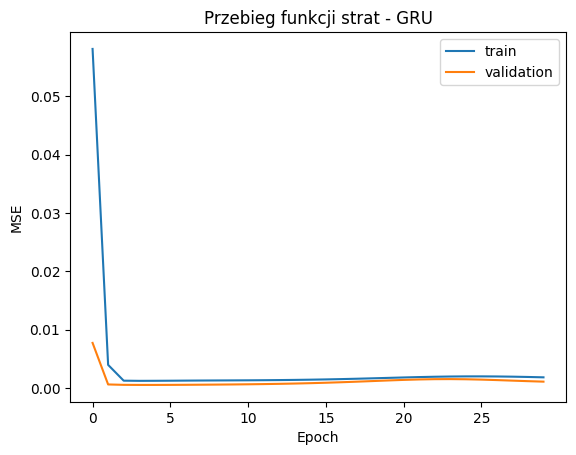

In [86]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title("Przebieg funkcji strat - GRU")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.xticks(np.arange(0, N_EPOCH, step=5))
plt.yticks(np.arange(0, history.history['loss'][0], step=0.01))
plt.legend()
plt.show()

In [87]:
predicted_price = model.predict(X_test, verbose=0)

In [88]:
rmse = sqrt(mean_squared_error(y_test, predicted_price))
print("Pierwiastek błędu średniokwadratowego (GRU): {:.4f}".format(rmse))

Pierwiastek błędu średniokwadratowego (GRU): 0.0332


In [89]:
model.save('PredictionData/Models/PredictionGRU.h5')

## 2.2 GRU - Training

In [ ]:
model = load_model('PredictionData/Models/PredictionGRU.h5')

In [46]:
train_predicted_price = model.predict(X_train, verbose=0)

In [47]:
y_scaler = load(open('PredictionData/y_scaler.pkl', 'rb'))
train_predict_index = np.load("PredictionData/train_predict_index.npy", allow_pickle=True)
rescaled_real_y = y_scaler.inverse_transform(y_train)
rescaled_predicted_y = y_scaler.inverse_transform(train_predicted_price)

In [48]:
predicted_train_result_GRU = pd.DataFrame()
for i in range(rescaled_predicted_y.shape[0]):
    y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                             index=train_predict_index[i:i + output_dim])
    predicted_train_result_GRU = pd.concat([predicted_train_result_GRU, y_predict], axis=1, sort=False)

In [49]:
real_train_price = pd.DataFrame()
for i in range(rescaled_real_y.shape[0]):
    y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                           index=train_predict_index[i:i + output_dim])
    real_train_price = pd.concat([real_train_price, y_train], axis=1, sort=False)

In [50]:
predicted_train_result_GRU['predicted_mean'] = predicted_train_result_GRU.mean(axis=1)
real_train_price['real_mean'] = real_train_price.mean(axis=1)

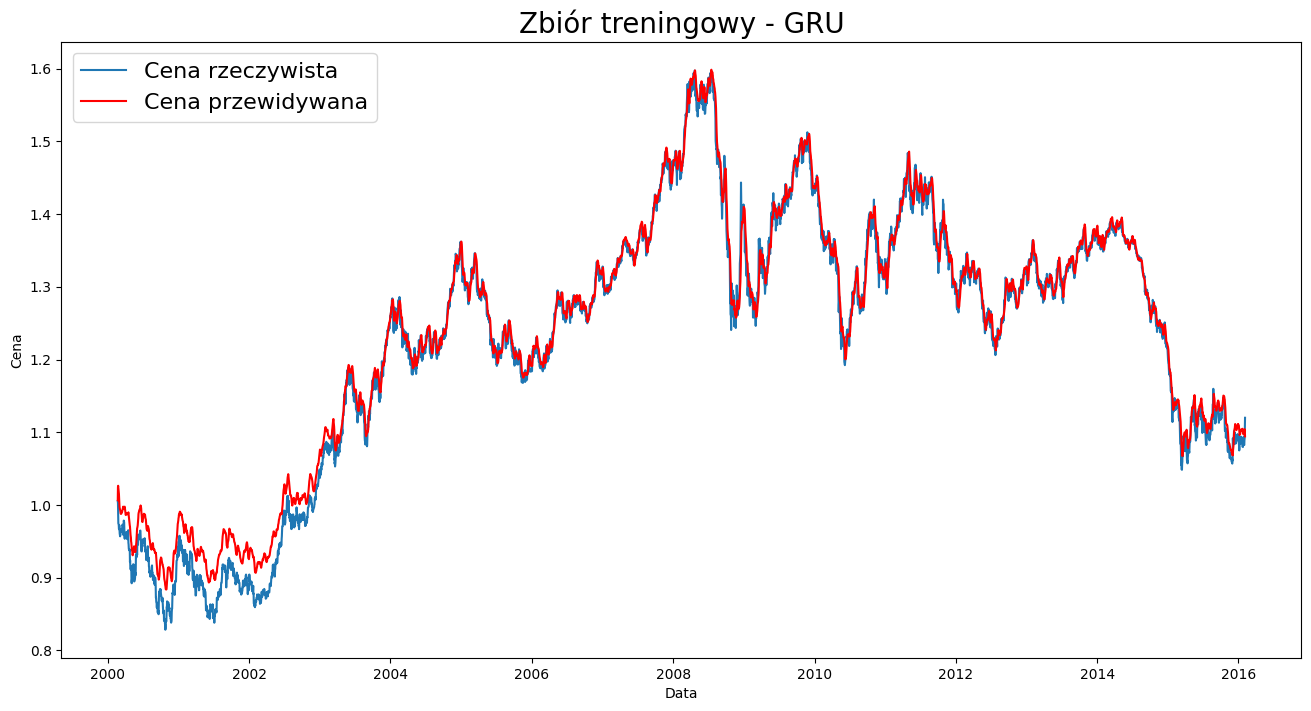

In [51]:
plt.figure(figsize=(16, 8))
plt.plot(real_train_price["real_mean"])
plt.plot(predicted_train_result_GRU["predicted_mean"], color='r')
plt.xlabel("Data")
plt.ylabel("Cena")
plt.legend(("Cena rzeczywista", "Cena przewidywana"), loc="upper left", fontsize=16)
plt.title("Zbiór treningowy - GRU", fontsize=20)
plt.show()

## 2.3 GRU - Testing

In [12]:
model = load_model('PredictionData/Models/PredictionGRU.h5')

In [13]:
test_predicted_price = model.predict(X_test, verbose=0)

In [14]:
y_scaler = load(open('PredictionData/y_scaler.pkl', 'rb'))
test_predict_index = np.load("PredictionData/test_predict_index.npy", allow_pickle=True)
rescaled_real_y = y_scaler.inverse_transform(y_test)
rescaled_predicted_y = y_scaler.inverse_transform(test_predicted_price)

In [15]:
predicted_test_result_GRU = pd.DataFrame()
for i in range(rescaled_predicted_y.shape[0]):
    y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                             index=test_predict_index[i:i + output_dim])
    predicted_test_result_GRU = pd.concat([predicted_test_result_GRU, y_predict], axis=1, sort=False)

In [16]:
real_test_price = pd.DataFrame()
for i in range(rescaled_real_y.shape[0]):
    y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                           index=test_predict_index[i:i + output_dim])
    real_test_price = pd.concat([real_test_price, y_train], axis=1, sort=False)

In [17]:
predicted_test_result_GRU['predicted_mean'] = predicted_test_result_GRU.mean(axis=1)
real_test_price['real_mean'] = real_test_price.mean(axis=1)

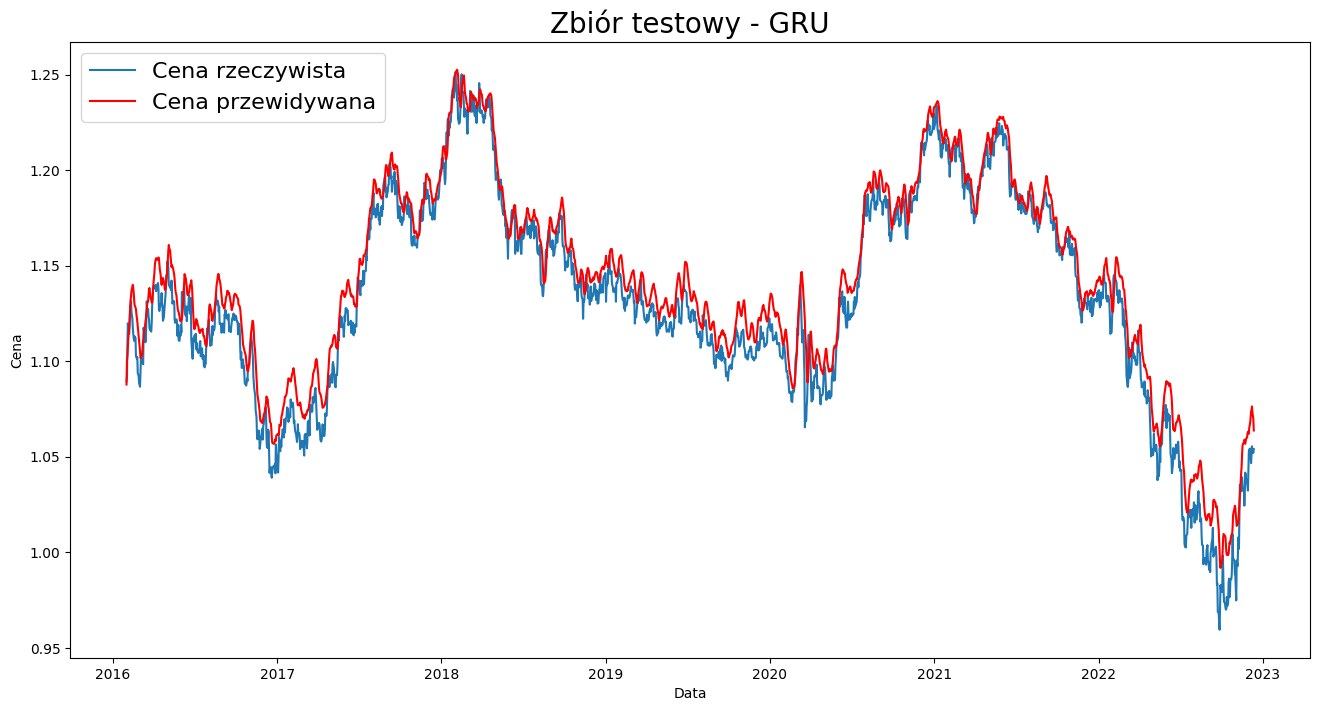

In [18]:
plt.figure(figsize=(16, 8))
plt.plot(real_test_price["real_mean"])
plt.plot(predicted_test_result_GRU["predicted_mean"], color='r')
plt.xlabel("Data")
plt.ylabel("Cena")
plt.legend(("Cena rzeczywista", "Cena przewidywana"), loc="upper left", fontsize=16)
plt.title("Zbiór testowy - GRU", fontsize=20)
plt.show()

## 3.1 LSTM

In [2]:
X_train = np.load("PredictionData/X_train.npy", allow_pickle=True)
y_train = np.load("PredictionData/y_train.npy", allow_pickle=True)
X_test = np.load("PredictionData/X_test.npy", allow_pickle=True)
y_test = np.load("PredictionData/y_test.npy", allow_pickle=True)

In [3]:
LR = 0.001
BATCH_SIZE = 32
N_EPOCH = 20

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [65]:
def basic_lstm(input_dim, feature_size):
    model = Sequential()
    model.add(LSTM(units=256, input_shape=(input_dim, feature_size)))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr = LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    return model, history

In [66]:
model, history = basic_lstm(input_dim, feature_size)
print(model.summary())

Epoch 1/20
156/156 - 12s - loss: 0.0074 - val_loss: 0.0024 - 12s/epoch - 74ms/step
Epoch 2/20
156/156 - 8s - loss: 0.0021 - val_loss: 0.0022 - 8s/epoch - 49ms/step
Epoch 3/20
156/156 - 7s - loss: 0.0019 - val_loss: 0.0014 - 7s/epoch - 45ms/step
Epoch 4/20
156/156 - 7s - loss: 0.0018 - val_loss: 0.0013 - 7s/epoch - 45ms/step
Epoch 5/20
156/156 - 7s - loss: 0.0017 - val_loss: 0.0012 - 7s/epoch - 46ms/step
Epoch 6/20
156/156 - 7s - loss: 0.0017 - val_loss: 0.0011 - 7s/epoch - 46ms/step
Epoch 7/20
156/156 - 7s - loss: 0.0017 - val_loss: 9.2941e-04 - 7s/epoch - 48ms/step
Epoch 8/20
156/156 - 7s - loss: 0.0017 - val_loss: 8.8151e-04 - 7s/epoch - 48ms/step
Epoch 9/20
156/156 - 7s - loss: 0.0017 - val_loss: 6.9935e-04 - 7s/epoch - 46ms/step
Epoch 10/20
156/156 - 7s - loss: 0.0017 - val_loss: 7.6227e-04 - 7s/epoch - 46ms/step
Epoch 11/20
156/156 - 7s - loss: 0.0018 - val_loss: 7.3233e-04 - 7s/epoch - 46ms/step
Epoch 12/20
156/156 - 7s - loss: 0.0018 - val_loss: 6.7170e-04 - 7s/epoch - 46ms/step

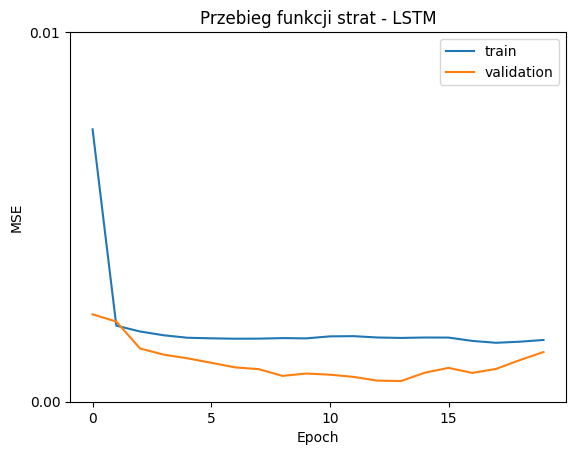

In [67]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title("Przebieg funkcji strat - LSTM")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.xticks(np.arange(0, N_EPOCH, step=5))
plt.yticks(np.arange(0, history.history['loss'][0] + 0.01, step=0.01))
plt.legend()
plt.show()

In [68]:
predicted_price = model.predict(X_test, verbose=0)

In [69]:
rmse = sqrt(mean_squared_error(y_test, predicted_price))
print("Pierwiastek błędu średniokwadratowego (LSTM): {:.4f}".format(rmse))

Pierwiastek błędu średniokwadratowego (LSTM): 0.0367


In [70]:
model.save('PredictionData/Models/PredictionLSTM.h5')

## 3.2 LSTM - Training

In [71]:
model = load_model('PredictionData/Models/PredictionLSTM.h5')

In [72]:
train_predicted_price = model.predict(X_train, verbose=0)

In [73]:
y_scaler = load(open('PredictionData/y_scaler.pkl', 'rb'))
train_predict_index = np.load("PredictionData/train_predict_index.npy", allow_pickle=True)
rescaled_real_y = y_scaler.inverse_transform(y_train)
rescaled_predicted_y = y_scaler.inverse_transform(train_predicted_price)

In [74]:
predicted_train_result_LSTM = pd.DataFrame()
for i in range(rescaled_predicted_y.shape[0]):
    y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                             index=train_predict_index[i:i + output_dim])
    predicted_train_result_LSTM = pd.concat([predicted_train_result_LSTM, y_predict], axis=1, sort=False)

In [75]:
real_train_price = pd.DataFrame()
for i in range(rescaled_real_y.shape[0]):
    y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                           index=train_predict_index[i:i + output_dim])
    real_train_price = pd.concat([real_train_price, y_train], axis=1, sort=False)

In [76]:
predicted_train_result_LSTM['predicted_mean'] = predicted_train_result_LSTM.mean(axis=1)
real_train_price['real_mean'] = real_train_price.mean(axis=1)

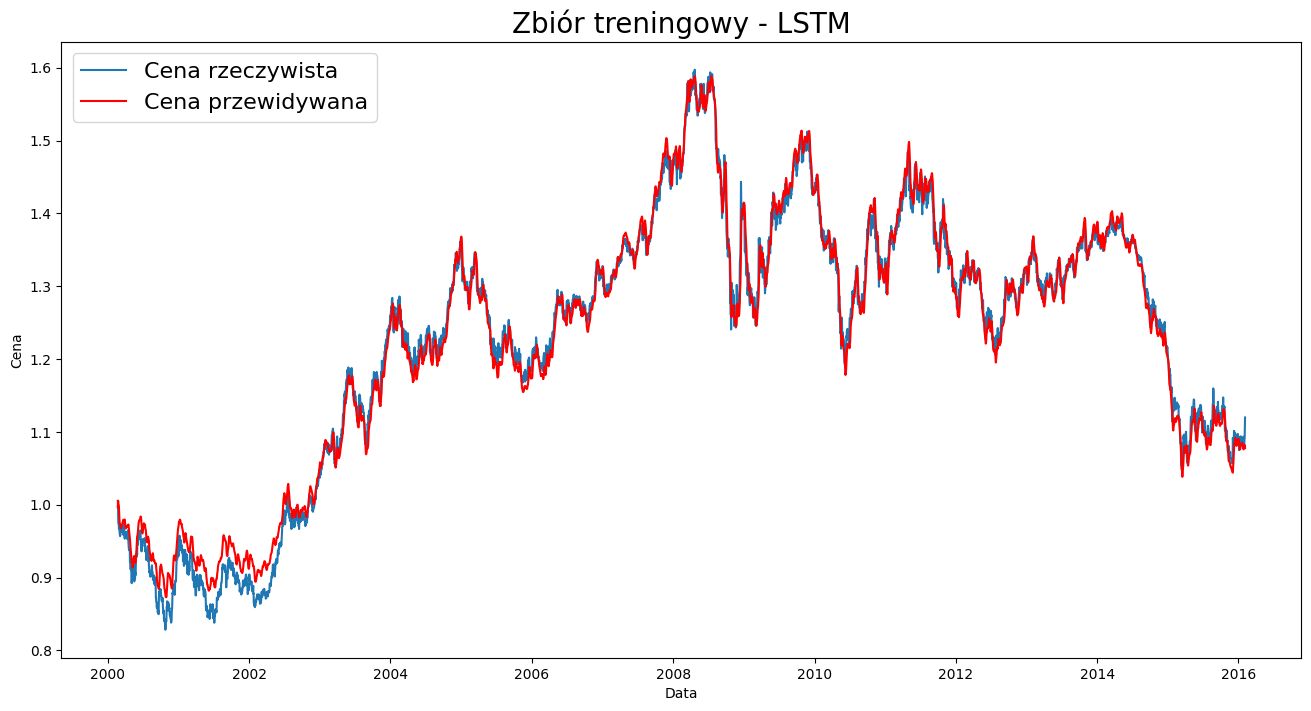

In [77]:
plt.figure(figsize=(16, 8))
plt.plot(real_train_price["real_mean"])
plt.plot(predicted_train_result_LSTM["predicted_mean"], color='r')
plt.xlabel("Data")
plt.ylabel("Cena")
plt.legend(("Cena rzeczywista", "Cena przewidywana"), loc="upper left", fontsize=16)
plt.title("Zbiór treningowy - LSTM", fontsize=20)
plt.show()

## 3.3 LSTM - Testing

In [4]:
model = load_model('PredictionData/Models/PredictionLSTM.h5')

In [5]:
test_predicted_price = model.predict(X_test, verbose=0)

In [6]:
y_scaler = load(open('PredictionData/y_scaler.pkl', 'rb'))
test_predict_index = np.load("PredictionData/test_predict_index.npy", allow_pickle=True)
rescaled_real_y = y_scaler.inverse_transform(y_test)
rescaled_predicted_y = y_scaler.inverse_transform(test_predicted_price)

In [7]:
predicted_test_result_LSMT = pd.DataFrame()
for i in range(rescaled_predicted_y.shape[0]):
    y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                             index=test_predict_index[i:i + output_dim])
    predicted_test_result_LSMT = pd.concat([predicted_test_result_LSMT, y_predict], axis=1, sort=False)

In [8]:
real_test_price = pd.DataFrame()
for i in range(rescaled_real_y.shape[0]):
    y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                           index=test_predict_index[i:i + output_dim])
    real_test_price = pd.concat([real_test_price, y_train], axis=1, sort=False)

In [9]:
predicted_test_result_LSMT['predicted_mean'] = predicted_test_result_LSMT.mean(axis=1)
real_test_price['real_mean'] = real_test_price.mean(axis=1)

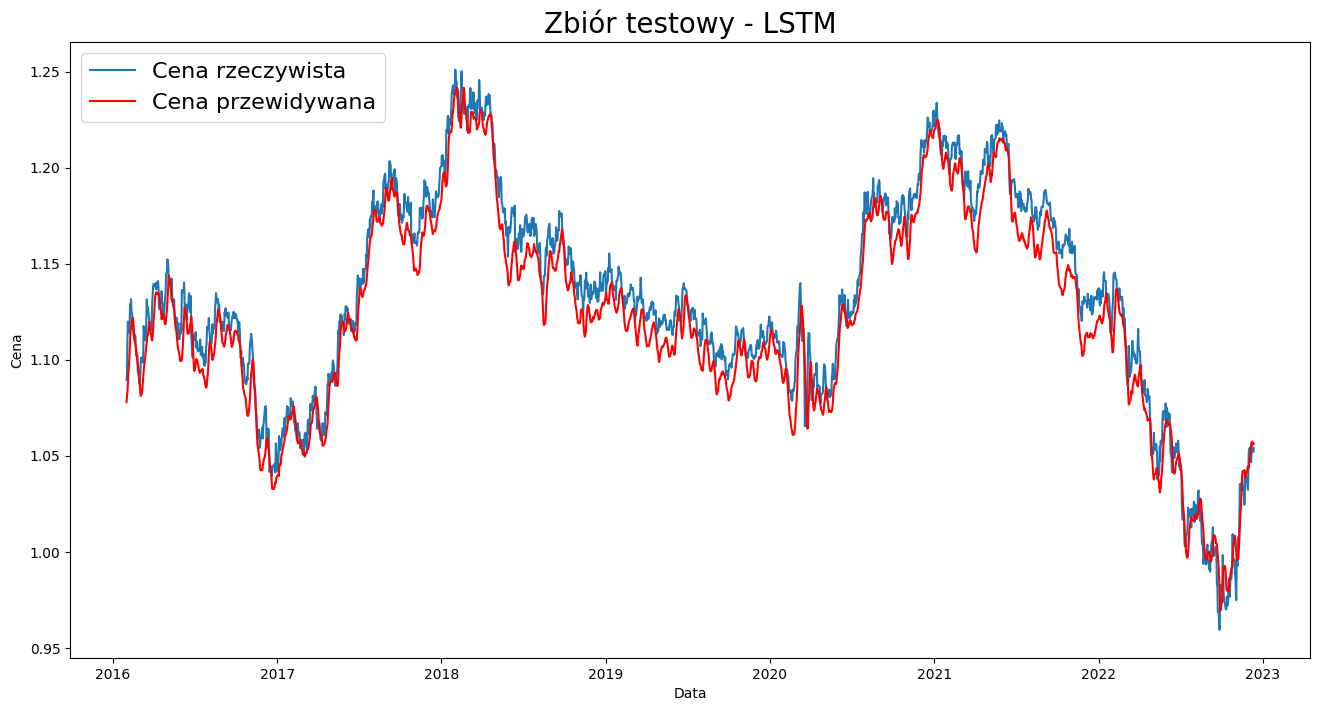

In [10]:
plt.figure(figsize=(16, 8))
plt.plot(real_test_price["real_mean"])
plt.plot(predicted_test_result_LSMT["predicted_mean"], color='r')
plt.xlabel("Data")
plt.ylabel("Cena")
plt.legend(("Cena rzeczywista", "Cena przewidywana"), loc="upper left", fontsize=16)
plt.title("Zbiór testowy - LSTM", fontsize=20)
plt.show()

## 4. GRU & LSTM - Compare

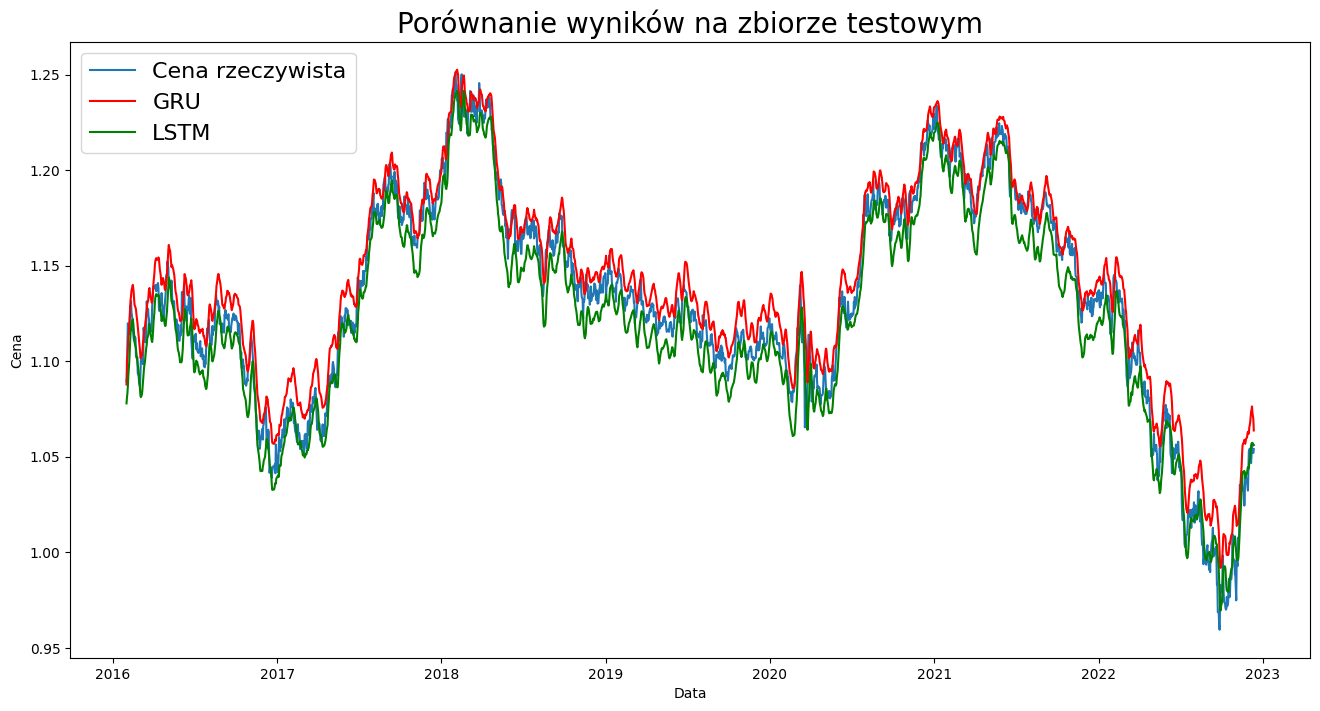

In [19]:
plt.figure(figsize=(16, 8))
plt.plot(real_test_price["real_mean"])
plt.plot(predicted_test_result_GRU["predicted_mean"], color='r')
plt.plot(predicted_test_result_LSMT["predicted_mean"], color='g')
plt.xlabel("Data")
plt.ylabel("Cena")
plt.legend(("Cena rzeczywista", "GRU", "LSTM"), loc="upper left", fontsize=16)
plt.title("Porównanie wyników na zbiorze testowym", fontsize=20)
plt.show()